In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## DEFINITIONS

In [3]:
def R_fun(s,e=1,s_max=1,Rmin=0.9,Rmax=0.99):
    r=Rmax+(Rmin-Rmax)*(s/s_max)/(e-(e-1)*(s/s_max))
    return(r)

def e_log(a,e=1,a_min=1e-12,a_max=1e-5,e_min=0.9,e_max=0.99):
    a=a_max*(np.log10(a)-np.log10(a_min))/(np.log10(a_max)-np.log10(a_min))
    epsilon=e_max+(e_min-e_max)*(a/a_max)/(e-(e-1)*(a/a_max))
    return(epsilon)

In [4]:
def construction_stress_periodic_1(T,dt,d1,d2,i_min,i_max):
    # d1: stress duration
    # d2: no stress duration
    # i_min, i_max: min and max stress intensity
    
    stress=np.array([])
    
    while np.size(stress)<=int(T/dt):
        stress=np.concatenate((stress,np.zeros(int(d2/dt)),np.repeat(np.random.uniform(i_min,i_max),int(d1/dt))))
    
    return stress[:(int(T/dt)+1)]

In [10]:
def replication(B,dt,r):
    # dt: time step
    # r: replication rate

    G=np.random.binomial(B,r*dt)
    return G

def lyse_stress(B,dt,t,d,s):
    # dt: time step
    # d: death rate
    # s: resistance rate
    
    N=np.reshape(np.sum(B,1),(nb_community,-1))
    L=np.random.binomial(B,(N*d+f2(t,s))*dt)
    return L

def infection(B,dt,a):
    # dt: time step
    # a: plasmid horizontal transfer rate
    
    I=np.random.binomial(np.reshape(B[:,0],(nb_community,-1)),B[:,1:]*a*dt)
    return I

def transfert_vertical(B,e):
    # dt: time step
    # e: plasmid vertical transfer rate

    D=np.random.binomial(B,e)
    return D

def innovation(B,dt,i):
    # dt: time step
    # i: innovation rate 
    
    N=np.random.binomial(B,i*dt)
    return N

def dispersion(B,dt,g): 
    # dt: time step
    # g: dispersal rate
    
    D=np.random.binomial(B,g*dt)    
    return D

In [11]:
def mges_incompatibles_stochastique(B0,dt,T,n,r,e,d,a,s,i,g):
    # dt: time step
    # T: final time
    # t0: initial time
    # n: number of community
    # r: vector of replication rate
    # e: vertical transfer probability
    # d: competition coefficient
    # a: vector of infection rate
    # s: vector of resistance rate
    # i: rate of mutation
    # g: diseprsion matrix
    
    nb_species_init=np.shape(B0)[1]
    
    for t in range(int(T/dt)):
        B0=np.int64(B0)
        B0=np.maximum(B0,0)
        B=B0
        for c1 in range(n):
            for c2 in range(c1+1,n):
                #if c2!=c1:
                G1_2=dispersion(B0[c1,:],dt,g[c1,c2])
                G2_1=dispersion(B0[c2,:],dt,g[c2,c1])
                B[c1,:]=B[c1,:]+G2_1-G1_2
                B[c2,:]=B[c2,:]+G1_2-G2_1
        
        # Local processes
        R=replication(B,dt,r)
        RP=transfert_vertical(R[:,1:],e)
        RNP=R[:,1:]-RP
        L=lyse_stress(B,dt,t,d,s)
        I=infection(B,dt,a)

        B[:,1:]=B[:,1:]+RP-L[:,1:]+I
        B[:,0]=B[:,0]+R[:,0]-L[:,0]-np.sum(I,1)+np.sum(RNP,1)
        
        # Innovation
        N=innovation(B[:,1:],dt,i)
        N_sum=np.sum(N>0)
        if(N_sum>0):
            N_ind_community=np.where(N>0)[0]
            N_ind_mge=np.where(N>0)[1]
            a_new=np.random.normal(np.log10(a[N_ind_mge]),0.1,N_sum)
            a_new=np.minimum(a_new,-5)
            a_new=np.maximum(a_new,-12)
            a_new=10**a_new
            s_new=np.random.normal(s[N_ind_mge-1],0.05,N_sum)
            s_new=np.minimum(s_new,1)
            s_new=np.maximum(s_new,0)
            a=np.append(a,a_new)
            s=np.append(s,s_new)
            r_new=R_fun(s_new,1)
            e_new=e_log(a_new,1)
            r=np.append(r,r_new)
            e=np.append(e,e_new)
            B[:,1:]=B[:,1:]-N
            B_new=np.zeros((nb_community,N_sum))
            N_ind=np.where(N>0)
            for j in range(N_sum):
                tmp=N_ind[0][j]
                B_new[tmp,j]=1
            B=np.append(B,B_new,axis=1)
        B=np.maximum(B,0)
        # Extinction
        B_ind=np.all(B[:,1:]==0,axis=0)
        if np.sum(B_ind)>0:
            tmp=np.where(B_ind==1)[0]+1
            B=np.delete(B,tmp,axis=-1)
            r=np.delete(r,tmp)
            s=np.delete(s,tmp)
            a=np.delete(a,tmp-1)
            e=np.delete(e,tmp-1)
        B0=B

    return(B,a,s)

## INITIAL CONDITIONS

In [5]:
np.random.seed(42)

nb_mges=200
nb_replicats=4
nb_community=nb_replicats*3
T=1000
dt=0.1

d=1e-6
a=[]
s=[]
S=np.zeros((nb_community,int(T/dt)+1))
for i in range(nb_replicats):
    S[i,:]=construction_stress_periodic_1(1000,0.1,95,5,0.9,0.9)
    S[i+nb_replicats,:]=construction_stress_periodic_1(1000,0.1,5,95,0.9,0.9)
    S[i+2*nb_replicats,:]=construction_stress_periodic_1(1000,0.1,50,50,0.9,0.9)

s=np.random.uniform(0.2,0.8,nb_mges)
a=10**(np.random.uniform(-11,-6,nb_mges))

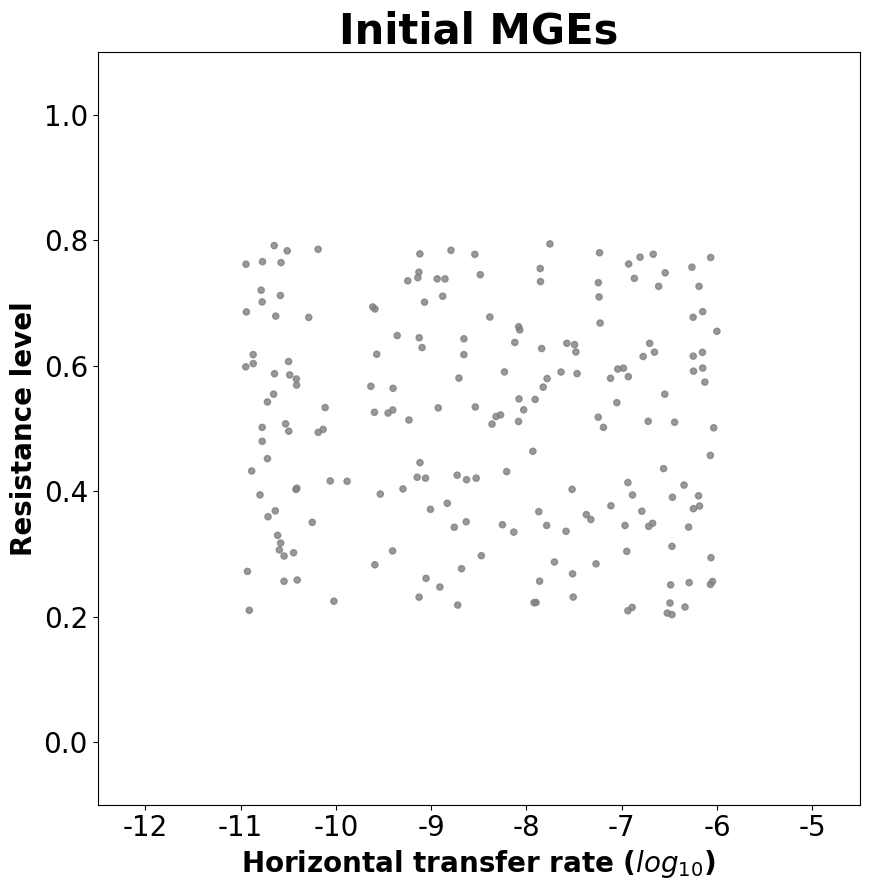

In [8]:
xticks=np.arange(-12,-4,1)
yticks=np.round(np.arange(0,1.1,0.2),1)
run=np.repeat(1,nb_mges)
init={'a_init':np.log10(a),'s_init':s,'density_init':np.repeat(20,nb_mges)}
init_df=pd.DataFrame(data=init)

############################## FIGURES
fig, axs = plt.subplots(1,1,figsize=(11,9),sharex=True,sharey=True)

scatter=axs.scatter(data=init_df, x="a_init", y="s_init", s="density_init",alpha=0.8,c="grey")
axs.set_xlabel("Horizontal transfer rate ($log_{10}$)",size=20,weight="bold")
axs.set_ylabel("Resistance level", size=20,weight="bold")
axs.set_title("Initial MGEs",size=30,weight="bold")

axs.set_xlim(-12.5,-4.5)
axs.set_ylim(-0.1,1.1)
axs.set_xticks(xticks)
axs.set_xticklabels(xticks,rotation=0,size=20)
axs.set_yticks(yticks)
axs.set_yticklabels(yticks,rotation=0,size=20)

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

## RESULTS SIMULATIONS

In [ ]:
repertory='simulated_data/unified_model_sensibility_analysis/'

In [9]:
np.random.seed(42)
def f2(t,s):
    return np.reshape(S[:,t],(nb_community,-1))*(1-s)


T=1000
dt=0.1
s_bis=np.concatenate(([0],s))
r=R_fun(s,1)
r_bis=np.concatenate(([1],r))
e=e_log(a,1)

B0=np.zeros((nb_community,nb_mges+1))
B0[:,0]=1000
B0[:,1:]=10

In [12]:
innovation_vector=np.array([0,1e-6,1e-5,1.25e-5,2.5e-5,5e-5,1e-4])
dispersion_vector=np.array([0,1e-9,1e-6,1e-5,1e-4,1e-3,1e-2])
nb_innovation=np.size(innovation_vector)
nb_dispersion=np.size(dispersion_vector)

nb_replicats=25

for i in range(nb_dispersion):
    print("i="+str(i))
    g=dispersion_vector[i]*np.ones((nb_community,nb_community))
    np.fill_diagonal(g,0)
    for j in range(nb_innovation):
        print("j="+str(j))
        sub_repertory=repertory+"dispersion="+str(dispersion_vector[i])+"_innovation="+str(innovation_vector[j])+"/"
        if not os.path.exists(sub_repertory):
            os.makedirs(sub_repertory)
        for k in range(nb_replicats):
            B,a_res,s_res=mges_incompatibles_stochastique(B0,dt,T,nb_community,r_bis,e,d,a,s_bis,innovation_vector[j],g)
            a_res_bis=np.concatenate(([0],a_res))
            a_res_bis=np.reshape(a_res_bis,(1,-1))
            s_res_bis=np.reshape(s_res,(1,-1))
            B_save=np.concatenate((B,a_res_bis,s_res_bis))
    
            np.savetxt(sub_repertory+"simulation_"+str(k)+".csv", B_save, delimiter=",")

i=0
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=1
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=2
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=3
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=4
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=5
j=0
j=1
j=2
j=3
j=4
j=5
j=6
i=6
j=0
j=1
j=2
j=3
j=4
j=5
j=6
